In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from allison.nn.layers import Relu,Linear
from allison.nn.optim import SGDMomentum
from allison.nn.tensor import Tensor,no_grad
from allison.nn.net import NeuralNetwork
from allison.nn.loss import CrossEntropyLoss
from allison.utils.functions.data import train_test_split
import pandas as pd

# Datos

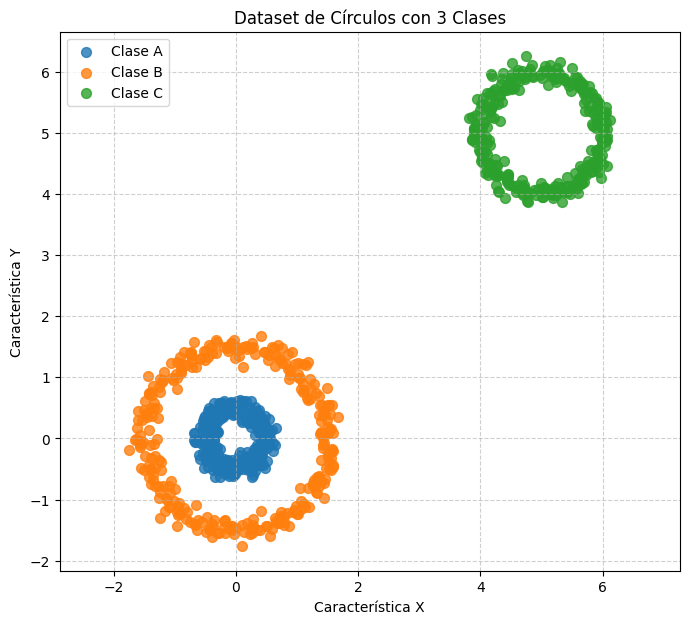

In [3]:
r1 = 0.5  
r2 = 1.5  
r3 = 1  

num_points = 300
thetas = np.linspace(0, 2 * np.pi, num_points) 


x1 = r1 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y1 = r1 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x2 = r2 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y2 = r2 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x3 = 5 + r3 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y3 = 5 + r3 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


plt.figure(figsize=(8, 7)) 


plt.scatter(x1, y1, s=50, label="Clase A", alpha=0.8) # Puntos de la Clase A
plt.scatter(x2, y2, s=50, label="Clase B", alpha=0.8) # Puntos de la Clase B
plt.scatter(x3, y3, s=50, label="Clase C", alpha=0.8) # Puntos de la Clase C

plt.xlabel("Característica X") 
plt.ylabel("Característica Y")
plt.title("Dataset de Círculos con 3 Clases")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.show() 


In [4]:
df = pd.DataFrame(
    {"x": x1.tolist()+x2.tolist()+x3.tolist(),
    "y": y1.tolist()+y2.tolist()+y3.tolist(),
    "labels":['A' for _ in range(num_points)]+['B' for _ in range(num_points)]+['C' for _ in range(num_points)]
    })

labels = df["labels"].unique()
labels2id = {label: i for i, label in enumerate(labels)}
id2labels = {v: k for k, v in labels2id.items()}

df["labels"] = df["labels"].map(labels2id)
df.head()

,x,y,labels
0,0.442308,-0.120187,0
1,0.538347,0.004760,0
2,0.474632,0.094663,0
3,0.525519,0.156666,0
4,0.307588,0.052485,0


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = Tensor(df_train[["x","y"]].values)
Y_train = Tensor(df_train[["labels"]].values)

X_test = Tensor(df_test[["x","y"]].values)
Y_test = Tensor(df_test[["labels"]].values)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


X_train shape: (720, 2)
Y_train shape: (720, 1)
X_test shape: (180, 2)
Y_test shape: (180, 1)


In [6]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 4)
        self.relu = Relu()
        self.fc2 = Linear(4, 4)
        self.fc3 = Linear(4, 3)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network()



criterion = CrossEntropyLoss(one_hot=False)
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-1, momentum=0.9)

# Training

In [7]:

# %%
# Bucle de entrenamiento mejorado
for epoch in range(10000 + 1):
    out = net(X_train)
    loss = criterion(Y_train,out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        loss = np.mean(loss.data)
        acc = np.mean(out.data.argmax(axis=1,keepdims=True) == Y_train.data)
        print(f"Epoch {epoch} | Loss: {loss:.4f} | Accuracy: {100*acc:.3f}%")
        if acc > 0.98:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break


Epoch 0 | Loss: 1.2110 | Accuracy: 48.472%
Epoch 10 | Loss: 0.5311 | Accuracy: 77.500%
Epoch 20 | Loss: 0.4406 | Accuracy: 78.611%
Epoch 30 | Loss: 0.4019 | Accuracy: 77.778%
Epoch 40 | Loss: 0.3747 | Accuracy: 80.000%
Epoch 50 | Loss: 0.3400 | Accuracy: 80.694%
Epoch 60 | Loss: 0.2921 | Accuracy: 88.472%
Epoch 70 | Loss: 0.2076 | Accuracy: 89.583%
Epoch 80 | Loss: 0.1159 | Accuracy: 99.167%
Entrenamiento completado en 80 epochs!


# Prediction

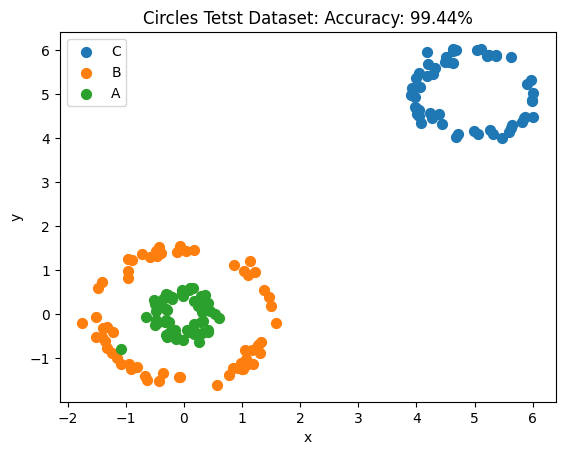

In [8]:
with no_grad():
    out = net(X_test)
    Y_pred = out.data.argmax(axis=1,keepdims=True).flatten()
    Y_data = Y_test.data.flatten()
    acc = np.mean(Y_pred == Y_data)

y_pred_labels = [id2labels[y] for y in Y_pred]
df_test['pred_labels'] = y_pred_labels


for label in df_test['pred_labels'].unique():
    x = df_test[df_test['pred_labels'] == label]['x']
    y = df_test[df_test['pred_labels'] == label]['y']

    plt.scatter(x,y,s=50,label=label)

plt.title(f"Circles Tetst Dataset: Accuracy: {100*acc:.2f}%")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

